## Binary Quantile Regression : A Walkthrough

This notebook is a walkthrough of all the concepts and ideas covered in the paper "Estimation and Applications of Quantiles in Deep Binary Classification". Appropriate headings are used to highlight the concepts covered.

Requirements: sklearn, pytorch, matplotlib, shap, pandas and jupyter

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, precision_recall_curve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils
import warnings
import matplotlib.pyplot as plt
import shap
import pandas as pd
import time
from IPython.display import HTML
import random

warnings.filterwarnings("ignore", category=UserWarning) # Prevents activation function warning messages 

Scaler = StandardScaler()
shap.initjs()

In [2]:
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle(for_next=True)

In [3]:
# Dataset Splitter function
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, threshold, Scaler,ditch_head=False):
    with open(dataset, 'r') as f:
        lines = f.readlines()
        
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        try:
            Y.append(float(all_columns[target_column]))
            X.append(point)
        except:
            pass
        
    X_arr = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = np.median(Y_arr)
    Y_arr_binary = np.where(Y_arr<=threshold,0,1)
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, threshold, Y_arr_binary


# Loss and Accuracy Computation functions

def cumLaplaceDistribution(y_pred,mean,standard_deviation,all_qs):
    term1 = ((1-all_qs) * (y_pred - mean))/standard_deviation
    term1.clamp_(max = 0) # Prevents NaN - Only one of term 1 or 2 is used, whichever is -ve
    lesser_term = all_qs * torch.exp(term1)
    term2 = (-1.0 * all_qs * (y_pred - mean))/standard_deviation
    term2.clamp_(max = 0) # Again, Prevents NaN
    greater_term = 1 - ((1-all_qs) * torch.exp(term2))
    mean_tensor = torch.ones_like(mean)
    y_mask = torch.div(y_pred,mean_tensor)
    y_mask[y_pred >= mean] = 1.0
    y_mask[y_pred < mean] = 0.0
    return ((1 - y_mask) * lesser_term )+  (y_mask * greater_term)


def logLikelihoodLoss(y_true,y_pred,mean,standard_deviation,all_qs):
    new_pred = y_pred
    prob = cumLaplaceDistribution(0.0,mean = new_pred,
                                  standard_deviation = standard_deviation,all_qs = all_qs)
    prob.clamp_(min = 1e-7,max = 1 - 1e-7)
    if_one = y_true * torch.log(1 - prob)
    if_zero = (1 - y_true) * torch.log(prob)
    final_loss = - 1 * torch.mean(if_one + if_zero)
    return final_loss

def customLoss(y_true, y_pred, mean, standard_deviation, all_qs, penalty):
    ind_losses = []
    for i,j in enumerate(all_qs):
        single_quantile_loss = logLikelihoodLoss(y_true[:,0],y_pred[:,i] ,
                                                 mean, standard_deviation, j)
        ind_losses.append(single_quantile_loss)
    zero = torch.Tensor([0]).to(device)
    dummy1 = y_pred[:,1:] - y_pred[:,:-1]
    dummy2 = penalty * torch.mean(torch.max(zero,-1.0 * dummy1))
    total_loss  = torch.mean(torch.stack(ind_losses)) +dummy2
    return total_loss

def customTestPred(y_pred,mean,standard_deviation,all_qs,batch_size = 1):
    acc = []
    cdfs = []
    val = (y_pred - mean)/standard_deviation 
    
    for xx in range(batch_size):
        if(y_pred < mean[xx]):
            lesser_term = all_qs * torch.exp((1.0 - all_qs) * torch.tensor(val[xx], dtype=torch.double)) 
            # Typecast above needed for some versions of torch
            lesser_term  = 1 - lesser_term
            cdfs.append(lesser_term.item())
            if(lesser_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
        
        elif(y_pred >= mean[xx]):
            greater_term = 1.0 - ((1.0-all_qs) * torch.exp(-1.0 * all_qs * torch.tensor(val[xx], dtype=torch.double)))
            # Typecast above needed for some versions of torch
            greater_term = 1 - greater_term
            cdfs.append(greater_term.item())
            if(greater_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
    return torch.Tensor(acc).to(device).reshape(-1,1),torch.Tensor(cdfs).to(device).reshape(-1,1)

def acc_tests(test_preds,test_labels):
    test_preds = np.array(test_preds).reshape(-1,1)
    test_labels = np.array(test_labels).reshape(-1,1)
    cdfs_acc,_ = customTestPred(0,test_preds,standard_deviation = 1,all_qs = torch.Tensor([0.5]),
                                batch_size = test_preds.shape[0])

    count = 0
    for i,j in zip(cdfs_acc,test_labels):
        if(i.item() == j[0]):
            count += 1
    return count/test_labels.shape[0]

def bce_test(preds, labels):
    count = 0
    for i,j in zip(preds,labels):
        if i < 0.5:
            prediction = 0
        else:
            prediction = 1
        if(prediction == j):
            count += 1
    return count/len(labels)

# Training and Testing Methods

def train(model,optimizer,loader,epochs,verbose=False):
    train_preds_Q = []
    train_labels = []
    model.train()
    
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        op_qs = model(inputs)
        lossQ = customLoss(labels.reshape(-1,1),op_qs, mean_is,std_is,all_qs,penalty)
        lossQ.backward()
        optimizer.step()
        
        for lag in op_qs[:,4].detach().reshape(-1,1):
            train_preds_Q.append(lag.item())
        for lag in labels.reshape(-1,1):
            train_labels.append(lag.item())
            
    acc_is_Q = acc_tests(train_preds_Q,train_labels)
    
    if verbose:
        print("[%d/%d] Train Acc Q : %f "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q

def test(model,loader,epochs,verbose=False):
    model.eval()
    test_preds_Q = []
    test_preds_bce = []
    test_labels = []
    with torch.no_grad():
        for i,j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op_qs = model(inputs)
            
            for lag in op_qs[:,4].detach().reshape(-1,1):
                test_preds_Q.append(lag.item())
            for lag in labels.reshape(-1,1):
                test_labels.append(lag.item())
                
    acc_is_Q = acc_tests(test_preds_Q,test_labels)
    
    if verbose:
        print("[%d/%d] Test Acc Q : %f  "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q

# Used in Robustness tests

def train_bce(model,opt,loader,epochs,verbose=False):
    bce_loss = nn.BCELoss()
    model.train()
    preds = []
    true_labels = []
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        op = model(inputs)
        loss = bce_loss(op,labels.reshape(-1,1))
        loss.backward()
        opt.step()
        for lag in op.detach().reshape(-1,1):
            preds.append(lag.item())
        for lag in labels.reshape(-1,1):
            true_labels.append(lag.item())
    acc = bce_test(preds, true_labels)
    if verbose:
        print("[%d/%d] Test Acc Q : %f  "%(epochs,total_epochs,acc))
    return acc

def test_bce(model,loader,epochs,verbose=False):
    model.eval()
    preds = []
    true_labels = []
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        op = model(inputs)
        for lag in op.detach().reshape(-1,1):
            preds.append(lag.item())
        for lag in labels.reshape(-1,1):
            true_labels.append(lag.item())
    acc = bce_test(preds, true_labels)
    if verbose:
        print("[%d/%d] Test Acc Q : %f  "%(epochs,total_epochs,acc))
    return acc

# Used for LALR tests

def lr_schedule_combined_sgd(model, loader, batch_size):
    Kz = 0.0
    model.eval()
    with torch.no_grad():
        for i,j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op = model.penultimate(inputs)
            activ = np.linalg.norm(op.detach().cpu().numpy())
            if activ > Kz:
                Kz = activ
    
    factor = 1    
    K_ = (factor * Kz) / (batch_size)
    lr = 1 / K_
    return lr

def train_adaptive_lr(model,optimizer,loader, epochs, verbose=False):
    train_preds_Q = []
    train_labels = []
    lr_val = lr_schedule_combined_sgd(model, loader, batch_is)
    optimizer.param_groups[0]['lr'] = lr_val
    model.train()
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        op_qs = model(inputs)
        lossQ = customLoss(labels.reshape(-1,1),op_qs, mean_is,std_is,all_qs,penalty)
        lossQ.backward()
        optimizer.step()
        for lag in op_qs[:,4].detach().reshape(-1,1):
            train_preds_Q.append(lag.item())
        for lag in labels.reshape(-1,1):
            train_labels.append(lag.item())
    
    acc_is_Q = acc_tests(train_preds_Q,train_labels)
    if verbose:
        print("[%d/%d] Train Acc Q : %f "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q


def quantileCDF(x, tau):
    if x>0:
        return 1 - tau*np.exp((tau-1)*x)
    else:
        return (1 - tau)*np.exp(tau*x)
    
def normalize(arr, mean, std):
    return (arr-mean)/std

# Flips 100*ratio% of the labels in target

def corrupt(target, ratio):
    result = target.copy()
    indices = np.random.choice(len(target),int(len(target)*ratio),replace=False)
    for i in indices:
        result[i] = np.abs(target[i]-1)    
    return result

# For interpolated quantiles and explainability
def kernel(u):
    return np.exp(-0.5*(u**2))/np.sqrt((2*np.pi))

def smoothed_quantile(tau, available_tau, available_quantiles,h=0.1):
    result = []
    for point in range(len(available_quantiles[0])):
        numerator = 0
        denominator = 0
        for t in range(len(available_tau)):
            weight = kernel((tau-available_tau[t])/h)/h
            numerator += weight*available_quantiles[t][point]
            denominator += weight
        result.append(numerator/denominator)  
    return result

def interpolated_mean_prob(sample, model):
    total = 0
    result = []
    sample_tensor = torch.Tensor(sample)
    model_ops = model(sample_tensor)
    available_quantiles = [0.1,0.2,0.3,0.4,0.5,
                          0.6,0.7,0.8,0.9]
    for op in model_ops.detach():
        total = 0
        available = []
        for q in range(9):
            available.append([op[q].item()])
        for i in range(1,20):
            total += smoothed_quantile(0.05*i,available_quantiles,available)[0]
        total/=19
        result.append(total)
    return np.array(result)

def create_xy_shapely(dataset, attribute_columns, target_column, delim, split_ratio, threshold, Scaler,ditch_head=False):
    with open(dataset, 'r') as f:
        lines = f.readlines()
        
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        try:
            Y.append(float(all_columns[target_column]))
            X.append(point)
        except:
            pass
        
    X_arr = np.asarray(X)
    X_unscaled = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = np.median(Y_arr)
    Y_arr_binary = np.where(Y_arr<=threshold,0,1)
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, X_unscaled

The cell above has all the common functions needed, and is rather large. For clarity it can be hidden from view.
Click on the toggle, after running the hide_toggle cell to view the code

In [4]:
# These are standard control variables
batch_is = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic=True
print("Torch Device:",device)
torch.set_default_dtype(torch.double) # Prevents bugs in certain PyTorch versions from showing up

# General Control Parameters for the Quantile loss. Need not be changed
lr_is = 1e-2
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0

# Tau tensor
all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
all_qs = all_qs.double()

Torch Device: cpu


In [5]:
# The standard network used for all tests

torch.manual_seed(111)
class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,50)
        self.l3 = nn.Linear(50,9)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x
    
    # Used in LALR
    def penultimate(self, x):
        op = F.leaky_relu(self.l1(x))
        op = F.leaky_relu(self.l2(op))
        return op
    
# For comparing against BCE in the robustness tests
class BCENetwork(nn.Module):
    def __init__(self, indim):
        super(BCENetwork,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,10)
        self.l3 = nn.Linear(10,1)
    
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.sigmoid(self.l3(x))
        return x

In [6]:
# Adjust the dataset details here. Refer the dataset_params.txt file for the specifics of each dataset
# Since this includes coverage results, make sure you use a regression dataset.

dataset = 'Datasets/Regression/abalone.csv'
mv = 9 # The threshold value
x_cols = list(range(8))
y_col = 8
separator = ","
remove_head = False
split_ratio = 0.2


---
# Coverage and Latent Recovery

This Section covers the Coverage results. After scaling, we compute the ratio of points whose latent values are less than the predicted value as per the quantile. For a well estimated quantile, this value should be close to Tau

In [7]:
# Experiment Control Parameters
total_runs = 10    # Number of times to run the experiment
total_epochs = 15  # No of training epochs per run
verbosity = False  # Toggle verbose training

In [8]:
results = [[0 for k in range(total_runs)] for i in range(11)]
misc_delta = [[0 for k in range(total_runs)] for i in range(5)]
misc_total = [[0 for k in range(total_runs)] for i in range(5)]
accept_total = [[0 for k in range(total_runs)] for i in range(5)]
data_for_auc = False
samples_per_conf_level =[[] for i in range(5)]
preds_per_conf_level =[[] for i in range(5)]

cov_dataset_generated = False

for iter in range(total_runs):
    print("Iteration:", iter+1)
    X_train,X_val,y_train,y_val, data_Y, data_X, threshval, all_classes = create_xy(dataset, x_cols, y_col, separator,
                                                                                    split_ratio, mv, Scaler,remove_head)
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)
    train_dataset = data_utils.TensorDataset(X_train, y_train)
    test_dataset = data_utils.TensorDataset(X_val, y_val)
    train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
    test_loader = data_utils.DataLoader(test_dataset,batch_size =512,pin_memory=True,shuffle = False,num_workers = 1)
    
    # This generates the coverage dataset to compare quantiles against the latent
    # Needs to be generated only once
    if not cov_dataset_generated:  
        all_labels = np.where(data_Y<=threshval,0,1)
        k = threshval/data_Y.mean()
        new_Y = data_Y * k
        cmp_Y = (new_Y - threshval)/new_Y.std()
        X_cov = torch.Tensor(data_X)
        y_cov = torch.Tensor(cmp_Y)

        cov_dataset = data_utils.TensorDataset(X_cov, y_cov)
        cov_loader = data_utils.DataLoader(cov_dataset, batch_size = 512, pin_memory=True,shuffle=False,num_workers = 1)
        cov_dataset_generated = True
        
    indim = X_train.shape[1]
    model = Network(indim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr_is)
    
    for epoch in range(total_epochs):
        acc_train = train(model,optimizer, train_loader,epoch,verbosity)
        
    with torch.no_grad():
        all_preds = [[] for i in range(9)]
        test_labels = []
        
        for i,j in cov_loader:
            inputs,labels = i.to(device),j.to(device)
            op_qs = model(inputs)
            
            for itemset in op_qs.detach():
                for quant in range(9):
                    all_preds[quant].append(itemset[quant].item())
            for lag in labels.reshape(-1,1):
                test_labels.append(lag.item())
            
    median_mean = np.mean(np.array(all_preds[4]).reshape(-1,1))
    median_std = np.std(np.array(all_preds[4]).reshape(-1,1))
    qss = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']
    cov_arr = [0,0,0,0,0,0,0,0,0]
    delta_total = [0,0,0,0,0]
    delta_misc = [0,0,0,0,0]
    rms_sum = 0
    correct_counter = 0
    for i in range(len(cmp_Y)):
        latent_value = test_labels[i]
        medv = (all_preds[4][i] - median_mean)/median_std
        rms_sum += (latent_value - medv)**2
        medprob = quantileCDF(all_preds[4][i], 0.5)
        for j in range(9):
            qv = (all_preds[j][i] - median_mean)/median_std
            if qv > latent_value:
                cov_arr[j] +=1
        start = 4
        left = start
        right = start
        found = False
        count = 0
        while (left>-1 and not found):
            q_left = all_preds[left][i]
            q_right = all_preds[right][i]
            p_left = quantileCDF(q_left, 0.5)
            p_right = quantileCDF(q_right, 0.5)
            left -=1
            right +=1
            if (q_left < 0.5 and q_right>0.5):
                found = True
            else:
                count +=1
        delta_total[count-1] +=1
        for temp in range(5):
            if count-1>=temp:
                accept_total[temp][iter] +=1
        if (all_labels[i]==0 and medprob<=0.5) or (all_labels[i]==1 and medprob>0.5):
            correct_pred = True
            correct_counter += 1
        else:
            correct_pred = False
            
        if not correct_pred:
            delta_misc[count-1] +=1
        if not data_for_auc:
            samples_per_conf_level[count-1].append(all_classes[i])
            preds_per_conf_level[count-1].append(medprob)


    rms = (rms_sum/len(cmp_Y))**0.5
    total = len(cmp_Y)
    for i in range(9):
        cov_arr[i] /= total
    results[0][iter] = correct_counter/len(cmp_Y)
    results[1][iter] = rms
    for i in range(9):
        results[i+2][iter] = cov_arr[i]
    for i in range(5):
        misc_delta[i][iter] = delta_misc[i]
        misc_total[i][iter] = delta_total[i]
    if not data_for_auc:
        data_for_auc = True

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


In [9]:
# Experiment Results. Accuracy, RMSE between the obtained Median and scaled latent, followed by per quantile coverage

result_name = ["Acc.   ","RMSE   ","Cov 0.1","Cov 0.2","Cov 0.3","Cov 0.4",
               "Cov 0.5", "Cov 0.6","Cov 0.7","Cov 0.8","Cov 0.9"]
op_string = "{} : {:.2f} +/- {:.2f}"
print("Coverage Results:")
print()
for i in range(len(results)):
    print(op_string.format(result_name[i],np.mean(results[i]), np.std(results[i])))

Coverage Results:

Acc.    : 0.80 +/- 0.00
RMSE    : 0.74 +/- 0.01
Cov 0.1 : 0.09 +/- 0.03
Cov 0.2 : 0.22 +/- 0.04
Cov 0.3 : 0.33 +/- 0.03
Cov 0.4 : 0.44 +/- 0.03
Cov 0.5 : 0.56 +/- 0.02
Cov 0.6 : 0.69 +/- 0.01
Cov 0.7 : 0.81 +/- 0.01
Cov 0.8 : 0.90 +/- 0.01
Cov 0.9 : 0.97 +/- 0.01


Below, we include a small plot of the recovered latent. To make the plot easier to see in 2D, we plot the scatter plot as a function of indices of the sorted latent, and the latent value. The appropriate index premutation is done to the quantiles as well

Latent Recovery:


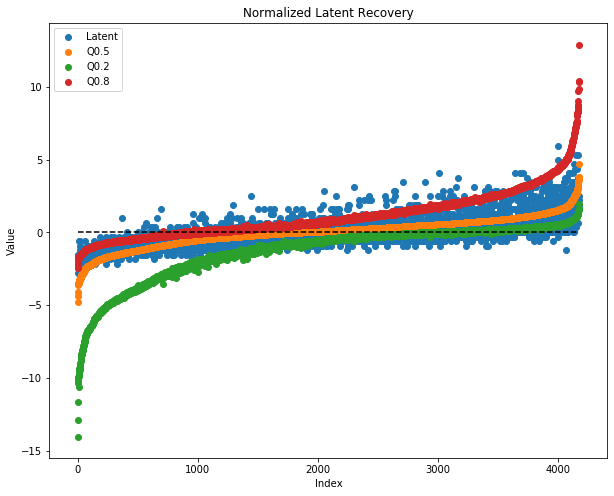

In [10]:
print("Latent Recovery:")
plt.figure(figsize=(10,8))
indices = np.argsort(all_preds[4], axis=None)
index_values = range(len(indices))
scaled_q50 = normalize(np.array(all_preds[4]),median_mean, median_std)
scaled_q20 = normalize(np.array(all_preds[1]),median_mean, median_std)
scaled_q80 = normalize(np.array(all_preds[7]),median_mean, median_std)

plt.scatter(index_values, cmp_Y[indices], label="Latent")
plt.scatter(index_values, scaled_q50[indices], label="Q0.5")
plt.scatter(index_values, scaled_q20[indices], label="Q0.2")
plt.scatter(index_values, scaled_q80[indices], label="Q0.8")
plt.plot([0,len(indices)], [0,0], linestyle="dashed", c="k")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.title("Normalized Latent Recovery")
plt.show()

---

# Confidence score based metrics

The next section covers the Delta-Based metrics. Here we compute the confidence score (delta) of each sample, and find the misclassification ratio of all samples belonging to a specific delta. In general, the likelihood of a sample with a certain delta being misclassified is 0.5-delta.

With this knowledge, we can set a task specific minimum delta value. If delta is below an acceptable confidence score, we refuse to make a prediction because we are not confident about it

In addition, at each delta, we include a retention rate parameter. This is because while it might make sense to only consider points above a certain threshold, we could lose a significant amount of points in the process. The per delta retention rate gives an idea of how well the classifier has managed to learn

In [10]:
# Delta based results - Misclassification Rate and Retention Rate

misc_rate_results = "Misc. Rate |"
delta_header      = "Delta      |"
ret_rate_results  = "Ret.  Rate |"

for i in range(5):
    delta_header += "{:.2f}".format(0.1*(i+1)) + " | "
    total_samples = sum(misc_total[i])
    total_misc = sum(misc_delta[i])
    v2sum = 0
    for j in range(len(misc_total[i])):
        if misc_total[i][j] != 0:
            v2sum += misc_delta[i][j] /misc_total[i][j] 
    v2ratio = v2sum/len(misc_total[i])
    misc_rate_results += "{:.2f}".format(v2ratio) + " | "

print("Misclassification vs Delta Results:")
print(delta_header)
print(misc_rate_results)

print()

print("Retention Rate vs Delta Results:")
print(delta_header)
for ret_rate in accept_total:
    ret_rate_results += "{:.2f}".format(np.mean(ret_rate)/len(data_Y)) + " | "
print(ret_rate_results)

Misclassification vs Delta Results:
Delta      |0.10 | 0.20 | 0.30 | 0.40 | 0.50 | 
Misc. Rate |0.41 | 0.34 | 0.25 | 0.15 | 0.03 | 

Retention Rate vs Delta Results:
Delta      |0.10 | 0.20 | 0.30 | 0.40 | 0.50 | 
Ret.  Rate |1.00 | 0.85 | 0.70 | 0.54 | 0.36 | 


In the cell below, the Per-Delta AUC-ROC curves and FP Curves are plotted

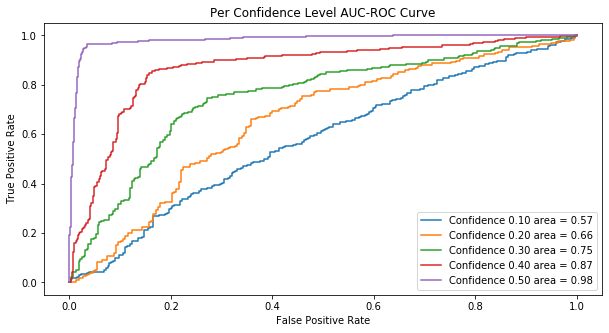

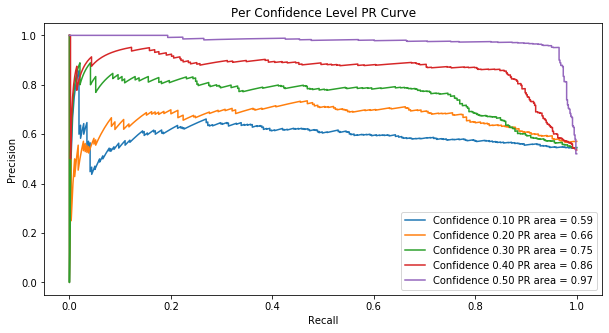

In [11]:
prec_array = []
recall_array = []
area_array_pr = []
area_array_roc = []
conf_array = []
fpr_array =[]
tpr_array =[]

for i in range(5):
    if len(samples_per_conf_level[i])!=0:
        fpr, tpr, _ = roc_curve(samples_per_conf_level[i], preds_per_conf_level[i])
        area_array_roc.append(auc(fpr, tpr))
        fpr_array.append(fpr)
        tpr_array.append(tpr)
        precision, recall, thresholds = precision_recall_curve(samples_per_conf_level[i], preds_per_conf_level[i])
        area_array_pr.append(auc(recall,precision))
        prec_array.append(precision)
        recall_array.append(recall)
        conf_array.append(i+1)


plt.figure(figsize=(10,5))
plt.title("Per Confidence Level AUC-ROC Curve")
for i in range(len(area_array_roc)):
    plt.plot(fpr_array[i], tpr_array[i], label='Confidence {:.2f} area = {:.2f}'.format(conf_array[i]*0.1, area_array_roc[i]))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()        
        
        

plt.figure(figsize=(10,5))
plt.title("Per Confidence Level PR Curve")
for i in range(len(area_array_pr)):
    plt.plot(recall_array[i], prec_array[i], label='Confidence {:.2f} PR area = {:.2f}'.format(conf_array[i]*0.1, area_array_pr[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

---
# Robustness Comparison

In this section we cover Robustness. As described in the paper, BQR is less susceptible to label noise than conventional BCE based classifiers. We train two identical classifiers on the same dataset, but having different losses. When we train, we flip a certain % of the labels to corrupt them, ranging from 0% to 40%. The accuracies are reported on the entire uncorrupted dataset 

In [9]:
# Experiment Control Parameters
iterations = 5    # Number of times to run the experiment
total_epochs = 20  # No of training epochs per run
verbosity = False  # Toggle verbose training

In [10]:
nr = [0,0.1,0.2,0.3,0.4] # Noise Ratios
median_average = []
bce_average = []
pred_range_average = []

for noise_ratio in nr:
    print("Noise Ratio",noise_ratio)
    bce_total = 0
    median_total = 0
    pred_delta_total = 0
    
    for iter in range(iterations):
        print("Iteration:",iter+1)
        X_train,X_val,y_train_legit,y_val, data_Y, data_X, threshval, all_classes = create_xy(dataset, x_cols, y_col, separator,
                                                                                    split_ratio, mv, Scaler,remove_head)
        y_train = corrupt(y_train_legit, noise_ratio)
        X_train = torch.Tensor(X_train)
        y_train = torch.Tensor(y_train)
        X_val = torch.Tensor(X_val)
        y_val = torch.Tensor(y_val)
        train_dataset = data_utils.TensorDataset(X_train, y_train)
        test_dataset = data_utils.TensorDataset(X_val, y_val)
        train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
        test_loader = data_utils.DataLoader(test_dataset,batch_size =64,pin_memory=True,shuffle = False,num_workers = 1)
        
        indim = X_train.shape[1]
        model = Network(indim)
        model = model.to(device)

        bce_model = BCENetwork(indim)
        bce_model = bce_model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = lr_is)
        bce_opt = torch.optim.Adam(bce_model.parameters(), lr=lr_is)
        
        for i in range(total_epochs):
            acc_train_med = train(model,optimizer, train_loader,i,verbosity)
            acc_train_bce = train_bce(bce_model,bce_opt, train_loader,i,verbosity)
            
    
        X_cov = torch.Tensor(data_X)
        y_cov = torch.Tensor(all_classes)

        cov_dataset = data_utils.TensorDataset(X_cov, y_cov)
        cov_loader = data_utils.DataLoader(cov_dataset, batch_size =64, pin_memory=True,shuffle=True,num_workers = 1)
        preds_Q = []
        prob_Q = []
        preds_bce = []
        true_labels = []
        for i,j in enumerate(cov_loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op_qs = model(inputs)
            op_bce = bce_model(inputs)
            for lag in op_qs[:,4].detach().reshape(-1,1):
                preds_Q.append(lag.item())
                prob_Q.append(quantileCDF(lag.item(),0.5))
            for lag in op_bce.detach().reshape(-1,1):
                preds_bce.append(lag.item())
            for lag in labels.reshape(-1,1):
                true_labels.append(lag.item()) 
            
        bce_total += bce_test(preds_bce, true_labels)/iterations
        median_total += acc_tests(preds_Q, true_labels)/iterations

    median_average.append(median_total)
    bce_average.append(bce_total)
    print("----------")


Noise Ratio 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
----------
Noise Ratio 0.1
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
----------
Noise Ratio 0.2
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
----------
Noise Ratio 0.3
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
----------
Noise Ratio 0.4
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
----------


In [11]:
nr_header = "Noise Ratio | "
bce_res   = "BCE         | "
bqr_res   = "BQR         | "
endstring = " | "
for i in range(len(nr)):
    bce_res += "{:.3f} ".format(bce_average[i]) + endstring
    bqr_res += "{:.3f} ".format(median_average[i]) + endstring
    nr_header += "{:.3f} ".format(nr[i]) + endstring
print("Robustness Results:")
print(nr_header)
print(bce_res)
print(bqr_res)

Robustness Results:
Noise Ratio | 0.000  | 0.100  | 0.200  | 0.300  | 0.400  | 
BCE         | 0.806  | 0.800  | 0.796  | 0.789  | 0.751  | 
BQR         | 0.808  | 0.806  | 0.800  | 0.792  | 0.762  | 


---
# Interpolated Quantiles & Explainability

In the next section, we cover interpolated quantiles and explainability. Here, we first obtain the variation of the latent with respect to a selected attribute, and also obtain the interpolated quantiles for the same. The median value is used for all the non-selected attributes, while the selected one is varied.

This, in turn allows us to view the range of values that correspond to a possible change in class.

After this, we also plot the Shapely summary statistics of the latent on a subset of the data, which shows us how various attributes affect the model's output in terms of the latent value.

In [19]:
attribute_index = 4 # This controls which attribute is allowed to vary
attribute_name = "Whole Weight" # Name of the attribute, used in the plots
latent_name = "Abalone Age" # Name of the function, used in the plots
attr_step_value = 0.1 # Step value of the attribute 
# The other attributes are replaced by the median value of the attribute

total_epochs = 20

In [20]:
X_train,X_val,y_train,y_val, data_Y, data_X_scaled, data_X_unscaled = create_xy_shapely(dataset, x_cols, y_col, separator,
                                                                                    split_ratio, mv, Scaler,remove_head)
shap_x_train = X_train.copy()
shap_x_val = X_val.copy()
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader = data_utils.DataLoader(test_dataset,batch_size =batch_is,pin_memory=True,shuffle = False,num_workers = 1)

indim = X_train.shape[1]
model = Network(indim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr_is)
for i in range(total_epochs):
    acc_train = train(model,optimizer,train_loader,i)

new_scaler = StandardScaler()
new_scaler.fit(data_X_unscaled)

col_index = attribute_index
attribute_array = np.arange(min(data_X_unscaled[:,col_index]), max(data_X_unscaled[:,col_index]),attr_step_value)

test_inputs  = []
med_values_left = []
med_values_right = []

for i in range(len(data_X_unscaled[0])):
    if i<col_index:
        med_values_left.append(np.mean(data_X_unscaled[:,i]))
    elif i>col_index:
        med_values_right.append(np.mean(data_X_unscaled[:,i]))

for i in range(len(attribute_array)):
    test_inputs.append(np.concatenate([med_values_left,attribute_array[i],med_values_right], axis=None))

scaled_input = new_scaler.transform(test_inputs)
X_tens = torch.Tensor(scaled_input)
y_tens = torch.Tensor([0]*len(scaled_input)) # irrelevant 

func_dataset = data_utils.TensorDataset(X_tens, y_tens)
func_loader = data_utils.DataLoader(func_dataset, batch_size =1024, pin_memory=True,shuffle=False,num_workers = 1)

model.eval()
outputs = [[] for i in range(9)]
probs = [[] for i in range(9)]
avg = []
with torch.no_grad():
    for i,j in func_loader:
        inputs,labels = i.to(device),j.to(device)
        op_qs = model(inputs)
        for itemset in op_qs.detach():
            total = 0
            for q in range(9):
                val = itemset[q].item()
                total+=val
                outputs[q].append(val)
                probs[q].append(quantileCDF(val,0.5))
            avg.append(total/9)
new_tau = []
for i in range(1,20):
    new_tau.append(i*0.05)
available_tau = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
interpolated = []
for i in new_tau:
    interpolated.append(smoothed_quantile(i, available_tau, outputs))

In [21]:
# These are the feature values used
print("Median of features")
for i in med_values_left:
    print(i)
print("Varying Feature:", attribute_name)
for i in med_values_right:
    print(i)

Median of features
0.9554704333253531
0.5239920995930094
0.40788125448886764
0.13951639932966242
Varying Feature: Whole Weight
0.35936748862820206
0.1805936078525257
0.23883085946851804


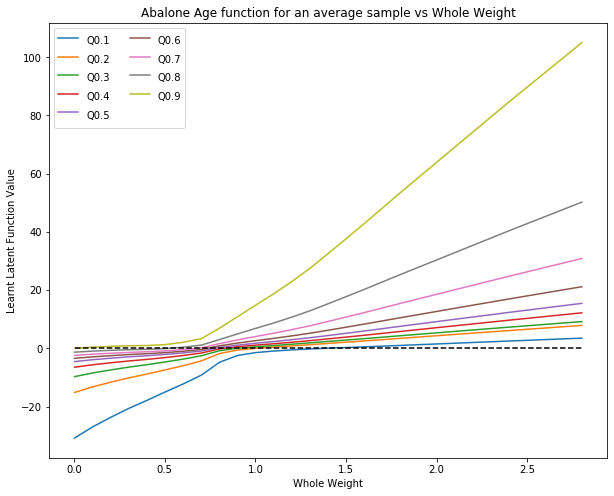

Interpolated Quantiles


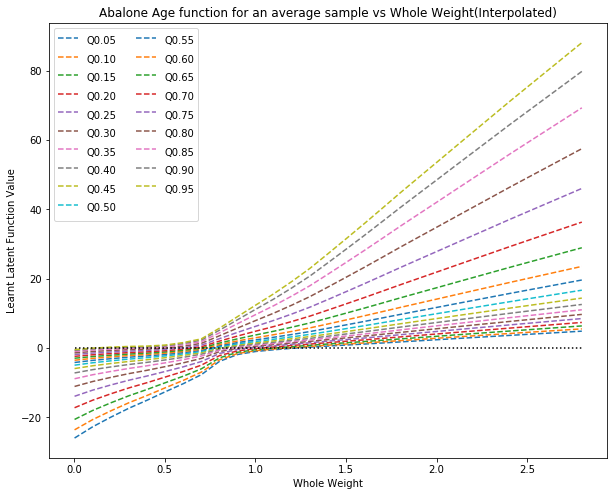

In [22]:
plt.figure(figsize=(10,8))
plt.title(latent_name + " function for an average sample vs " + attribute_name)
for i in range(9):
    plt.plot(attribute_array, outputs[i],label="Q0."+str(i+1))
plt.plot([min(attribute_array), max(attribute_array)],[0,0], linestyle="dashed", c="k")
plt.ylabel("Learnt Latent Function Value")
plt.xlabel(attribute_name)
plt.legend(ncol=2,handleheight=2.4, labelspacing=0.05)
plt.show()

print("Interpolated Quantiles")

plt.figure(figsize=(10,8))
plt.title(latent_name + " function for an average sample vs "+attribute_name + "(Interpolated)")
for i in range(19):
    plt.plot(attribute_array, interpolated[i],label="Q{:.2f}".format(new_tau[i]), linestyle="dashed")
plt.plot([min(attribute_array), max(attribute_array)],[0,0], linestyle="dotted", c="k")
plt.ylabel("Learnt Latent Function Value")
plt.xlabel(attribute_name)
plt.legend(ncol=2,handleheight=2.4, labelspacing=0.05)
plt.show()

The cell below shows the Shapely Summary Statistics

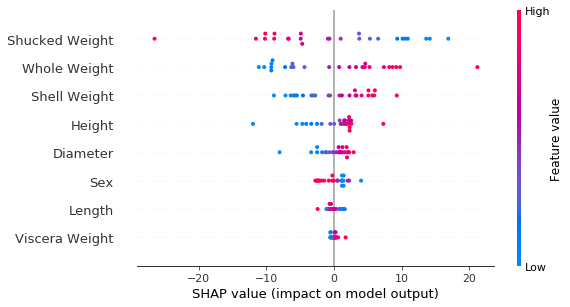

In [22]:
f = lambda x: interpolated_mean_prob(x,model)

# These are the features. Change appropriately as per the dataset
ds_col_names = ["Sex","Length","Diameter", "Height","Whole Weight", 
                "Shucked Weight", "Viscera Weight", "Shell Weight"]

sample_shap_val = shap_x_val[:25]  # We use a small sample here because of the computation time
df_dict ={}
col_headers = []
for i in range(len(shap_x_val[0])):
    df_dict[ds_col_names[i]] = sample_shap_val[:,i]
    


shap_dset = pd.DataFrame(df_dict)
    

explainer = shap.KernelExplainer(f, shap_dset)
shap_values = explainer.shap_values(shap_dset, n_samples=len(shap_dset))
shap.summary_plot(shap_values,shap_dset)

---
# Lipschitz Adaptive Learning Rates for SGD

This final section covers the Lipschitz Adaptive Learning Rate. We create 3 identical classifiers, using SGD and compute the number of epochs required to reach a target accuracy.

In [6]:
# Set the target accuracy here
target_acc = 0.8
print_trigger = 10 # No. of epochs in between prints
max_epochs = 100 # Max no. of epochs

In [7]:
X_train,X_val,y_train,y_val, data_Y, data_X, threshval, all_classes = create_xy(dataset, x_cols, y_col, separator,
                                                                                    split_ratio, mv, Scaler,remove_head)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_cov = torch.Tensor(data_X)
y_cov = torch.Tensor(all_classes)
cov_dataset = data_utils.TensorDataset(X_cov, y_cov)
cov_loader = data_utils.DataLoader(cov_dataset, batch_size =512, pin_memory=True,shuffle=False,num_workers = 1)

train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
train_loader = data_utils.DataLoader(train_dataset, batch_size = batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader = data_utils.DataLoader(test_dataset,batch_size =512,pin_memory=True,shuffle = False,num_workers = 1)

indim = X_train.shape[1]

model_fixed = Network(indim)
model_fixed = model_fixed.to(device)
optimizer_fixed = torch.optim.SGD(model_fixed.parameters(), lr = 0.01)

model_adapt = Network(indim)
model_adapt = model_adapt.to(device)
optimizer_adapt = torch.optim.SGD(model_adapt.parameters(), lr = lr_is)

acc_train_fixed_1 = 0
acc_train_fixed_2 = 0
acc_test_fixed_1 = 0
acc_test_fixed_2 = 0
acc_train_adapt = 0
acc_test_adapt = 0

epoch_count_fixed_1 = 0
epoch_count_fixed_2 = 0
epoch_count_adapt = 0

et_1 = 0
et_2 = 0
et_adapt = 0

while (acc_train_fixed_1 < target_acc) and epoch_count_fixed_1<max_epochs:
    fixed_start = time.time()
    acc_train_fixed_1 = train(model_fixed,optimizer_fixed,train_loader, epoch_count_fixed_1)
    fixed_end = time.time()
    if epoch_count_fixed_1==0:
        timeval = (fixed_end-fixed_start)/60
        print("Epoch time: {:.4f}".format(timeval))
        et_1 = timeval
    acc_test_fixed_1  = test(model_fixed,cov_loader,epoch_count_fixed_1)
    if epoch_count_fixed_1 %print_trigger ==0:
        print("Fixed epoch:", epoch_count_fixed_1+1, "{:.3f} {:.3f}".format(acc_train_fixed_1, acc_test_fixed_1))
    epoch_count_fixed_1 +=1
print("LR 0.01 Complete")
print(acc_train_fixed_1, acc_test_fixed_1)
print("--------")

model_fixed = Network(indim)
model_fixed = model_fixed.to(device)
optimizer_fixed = torch.optim.SGD(model_fixed.parameters(), lr = 0.1)

while (acc_train_fixed_2 < target_acc) and epoch_count_fixed_2<max_epochs:
    fixed_start = time.time()
    acc_train_fixed_2 = train(model_fixed,optimizer_fixed,train_loader, epoch_count_fixed_2)
    fixed_end = time.time()
    if epoch_count_fixed_2==0:
        timeval = (fixed_end-fixed_start)/60
        print("Epoch time: {:.4f}".format(timeval))
        et_2 = timeval
    acc_test_fixed_2  = test(model_fixed,cov_loader,epoch_count_fixed_2)
    if epoch_count_fixed_2 %print_trigger ==0:
        print("Fixed epoch:", epoch_count_fixed_2+1, "{:.3f} {:.3f}".format(acc_train_fixed_2, acc_test_fixed_2))
    epoch_count_fixed_2 +=1
print("LR 0.1 Complete")
print(acc_train_fixed_2, acc_test_fixed_2)
print("--------")


epoch_count_adapt = 0
while (acc_train_adapt < target_acc):
    adapt_start = time.time()
    acc_train_adapt = train_adaptive_lr(model_adapt,optimizer_adapt,train_loader, epoch_count_adapt)
    adapt_end = time.time()
    if epoch_count_adapt==0:
        print("Epoch time: {:.4f}".format((adapt_end-adapt_start)/60))
        et_adapt = (adapt_end-adapt_start)/60
    acc_test_adapt  = test(model_adapt,cov_loader,epoch_count_adapt)
    if epoch_count_adapt %50 == 0:
        print("Adapt epoch:", epoch_count_adapt+1, "{:.3f} {:.3f}".format(acc_train_adapt, acc_test_adapt))
    epoch_count_adapt +=1
print("LR 0.1 Complete")
print(acc_train_adapt, acc_test_adapt)
print("--------")



Epoch time: 0.0227
Fixed epoch: 1 0.558 0.600
Fixed epoch: 11 0.739 0.742
Fixed epoch: 21 0.733 0.733
Fixed epoch: 31 0.735 0.735
Fixed epoch: 41 0.735 0.735
Fixed epoch: 51 0.736 0.735
Fixed epoch: 61 0.737 0.736
Fixed epoch: 71 0.736 0.736
Fixed epoch: 81 0.735 0.736
Fixed epoch: 91 0.735 0.736
LR 0.01 Complete
0.7351092487279258 0.7356954752214508
--------
Epoch time: 0.0250
Fixed epoch: 1 0.648 0.734
Fixed epoch: 11 0.735 0.733
Fixed epoch: 21 0.742 0.744
Fixed epoch: 31 0.756 0.756
Fixed epoch: 41 0.776 0.777
Fixed epoch: 51 0.786 0.790
Fixed epoch: 61 0.789 0.794
Fixed epoch: 71 0.795 0.797
Fixed epoch: 81 0.799 0.800
LR 0.1 Complete
0.8012571086501048 0.8024898252334212
--------
Epoch time: 0.0357
Adapt epoch: 1 0.654 0.748
LR 0.1 Complete
0.8012571086501048 0.7998563562365334
--------


In [8]:
print("LR Type    | Epochs | Time Per Epoch")
print("Fixed 0.01 | {}     | {:.2f}".format(epoch_count_fixed_1, et_1))
print("Fixed 0.1  | {}     | {:.2f}".format(epoch_count_fixed_2, et_2))
print("LALR       | {}     | {:.2f}".format(epoch_count_adapt, et_adapt))

LR Type    | Epochs | Time Per Epoch
Fixed 0.01 | 100     | 0.02
Fixed 0.1  | 86     | 0.03
LALR       | 14     | 0.04
